# How to use

In [1]:
import torch
import numpy as np
import SimpleITK as sitk
from matplotlib import pyplot as plt
from ptimz.utils.viz import plot_semseg

## Load a fetal brain T2-weighted image
Please download [Image](https://github.com/RimeT/ptimz/releases/download/v0.0.1-np/sub-001_rec-mial_T2w.nii.gz) to your local path.  
[Ground Truth](https://github.com/RimeT/ptimz/releases/download/v0.0.1-np/wm_sub-001_rec-mial_dseg.nii.gz)

In [2]:
# replace image_path with your own path 
image_path = 'sub-001_rec-mial_T2w.nii.gz'
imageitk = sitk.ReadImage(image_path)
origin_size = imageitk.GetSize()
print("ITK Image Size", origin_size)
print("Spacing", imageitk.GetSpacing())

ITK Image Size (256, 256, 256)
Spacing (0.5468999743461609, 0.5468999743461609, 0.5468999743461609)


## Convert image to numpy array

In [3]:
image = sitk.GetArrayFromImage(imageitk)
# add channel axis
image = np.expand_dims(image, axis=0)
print('image with axis', image.shape)

image with axis (1, 256, 256, 256)


## Use monai package to do data transformation

In [4]:
from monai import transforms as mnf
fn = mnf.Compose([
    # resize image to 224x224x224
    mnf.Resize((224, 224, 224)),
    # rescale the intensity
    mnf.ScaleIntensity()
])

image = fn(image)
print(f"shape {image.shape} new intensity ({np.min(image)}, {np.max(image)})")

shape (1, 224, 224, 224) new intensity (0.0, 1.0)


## Use ptimz to load deep learning models

In [5]:
import ptimz

list all models

In [6]:
print(ptimz.list_models())

['litehrnet_cls2d', 'litehrnet_cls3d', 'litehrnet_seg2d', 'litehrnet_seg3d', 'resnet10_1d', 'resnet10_2d', 'resnet10_3d', 'resnet10d_1d', 'resnet10d_2d', 'resnet10d_3d', 'resnet18_1d', 'resnet18_2d', 'resnet18_3d', 'resnet18d_1d', 'resnet18d_2d', 'resnet18d_3d', 'resnet34_1d', 'resnet34_2d', 'resnet34_3d', 'resnet34d_1d', 'resnet34d_2d', 'resnet34d_3d', 'resnet50_1d', 'resnet50_2d', 'resnet50_3d', 'resnet50d_1d', 'resnet50d_2d', 'resnet50d_3d', 'resnet50unet_1d', 'resnet50unet_2d', 'resnet50unet_3d', 'resnet101_1d', 'resnet101_2d', 'resnet101_3d', 'resnet101d_1d', 'resnet101d_2d', 'resnet101d_3d', 'resnet152_1d', 'resnet152_2d', 'resnet152_3d', 'resnet152d_1d', 'resnet152d_2d', 'resnet152d_3d', 'resunet_3d']


Or find models with key words

In [7]:
print(ptimz.list_models("*hrnet*"))

['litehrnet_cls2d', 'litehrnet_cls3d', 'litehrnet_seg2d', 'litehrnet_seg3d']


List all pretrained weights

In [8]:
print(ptimz.list_pretrained_names())

['ctliver|resunet_3d', 'fetal_whitematter|litehrnet_seg3d', 'multiplesclerosis|resnet50unet_2d']


Find available pretrained weights by model name

In [9]:
print(ptimz.list_pretrained_names("litehrnet_seg3d"))

['fetal_whitematter']


construct litehrnet_seg3d and load fetal_whitematter
input channels is 1 and output classes is 2

In [10]:
model = ptimz.create_model("litehrnet_seg3d", pretrained="fetal_whitematter", in_chans=1, num_classes=2)

### Transfer learning based on pretrained weights

Now we want to input T1w, T1post, T2w, T2FLAIR, segment 6 types of objects.  
**4 channels input and 6 channels output**

In [11]:
my_input = torch.rand(size=(1, 4, 224, 224, 224))
my_model = ptimz.create_model("litehrnet_seg3d", pretrained="fetal_whitematter", in_chans=4, num_classes=6)
with torch.no_grad():
    my_output =my_model(my_input)
print(my_output.shape)

torch.Size([1, 6, 224, 224, 224])


**Let's check if the weights have been transfered**

In [29]:
# print(model.state_dict().keys())
print("origin model mean weights", torch.mean(model.state_dict()['stem.conv1.conv.weight']))
print("origin model mean weights", torch.mean(my_model.state_dict()['stem.conv1.conv.weight']))

origin model mean weights tensor(-0.0001, device='cuda:0')
origin model mean weights tensor(-0.0001)


input tensor should have a batch channel

In [13]:
input_tensor = torch.Tensor(image)
input_tensor = input_tensor.unsqueeze(dim=0)
print(f"input shape {input_tensor.shape}")

input shape torch.Size([1, 1, 224, 224, 224])


## Inference

In [14]:
from time import time
t1 = time()
with torch.no_grad():
    output = model(input_tensor)
print(f"CPU inference time: {time()-t1}  output shape {output.shape}")

CPU inference time: 20.188251495361328  output shape torch.Size([1, 2, 224, 224, 224])


GPU inference

In [15]:
from time import time

t1 = time()
input_tensor = input_tensor.cuda()
model = model.cuda()
with torch.no_grad():
    output = model(input_tensor)
output = output.cpu()
print(f"GPU inference time: {time()-t1}  output shape {output.shape}")

GPU inference time: 1.9089529514312744  output shape torch.Size([1, 2, 224, 224, 224])


## Plot

mask shape = (2, 224, 224, 224)
display slice 112


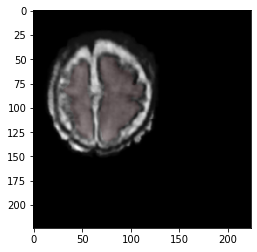

In [16]:
# remove batch axis
output = output[0].numpy()

print(f"mask shape = {output.shape}")
plot_semseg(image[0], output, alpha=0.2)
plt.show()

# Resize the mask back

In [17]:
mask = np.argmax(output, axis=0)
maskitk = sitk.GetImageFromArray(mask)

from ptimz.data.transforms import itkimage_resize
maskitk = itkimage_resize(maskitk, origin_size, sitk.sitkNearestNeighbor)
print(maskitk.GetSize())

(256, 256, 256)


# Save mask into nifty nii

In [18]:
# copy spacing info
maskitk.CopyInformation(imageitk)
print(maskitk.GetSpacing())

out_path = 'sub-001_seg.nii.gz'
sitk.WriteImage(maskitk, out_path)
print(f"Save mask to {out_path}")

(0.5468999743461609, 0.5468999743461609, 0.5468999743461609)
Save mask to sub-001_seg.nii.gz
